In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# train.json 파일 경로 설정
json_path = '/data/ephemeral/home/dataset/train.json'

# JSON 파일 로드
with open(json_path) as f:
    data = json.load(f)

# 정보 추출
annotations = data['annotations']
categories = data['categories']

# category_id와 해당 이름 매핑을 위한 사전 생성
category_map = {category['id']: category['name'] for category in categories}


In [11]:
# 객체 정보에서 필요한 데이터 추출
bbox_data = [ann['bbox'] for ann in annotations]
category_ids = [ann['category_id'] for ann in annotations]
category_names = [category_map[ann['category_id']] for ann in annotations]
iscrowd_flags = [ann['iscrowd'] for ann in annotations]
areas = [ann['area'] for ann in annotations]

# DataFrame 생성
df = pd.DataFrame({
    'bbox': bbox_data,
    'Category Name': category_names,
    'iscrowd': iscrowd_flags,
    'Area': areas
})

객체 겹침 여부 분석(iscrowd)

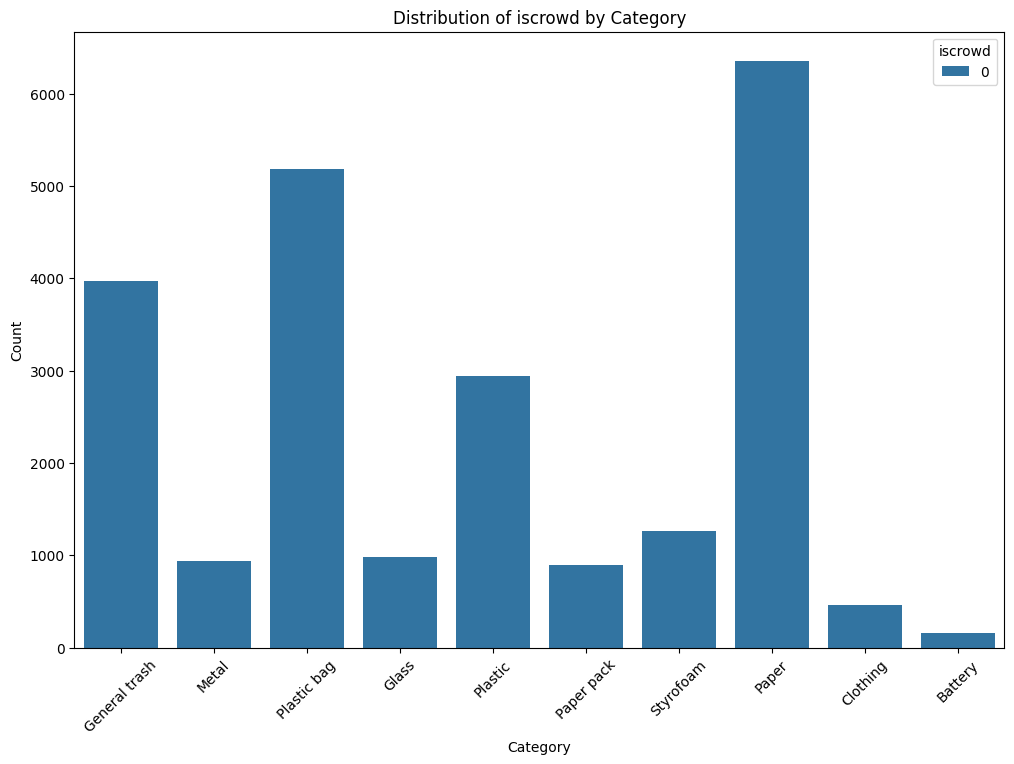

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Category Name', hue='iscrowd')
plt.title('Distribution of iscrowd by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='iscrowd')
plt.show()

객체 Bounding Box 위치 분석 

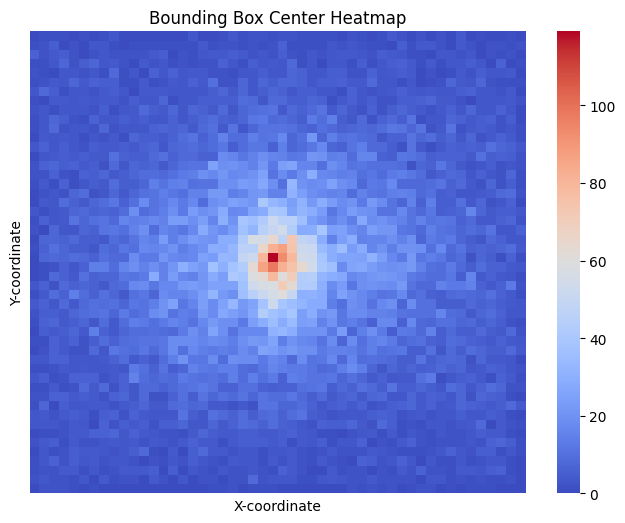

In [13]:
#annotations 데이터에서 bbox 정보를 추출하여 중심 좌표를 계산
centers_x = []
centers_y = []

for ann in data['annotations']:
    bbox = ann['bbox']
    x, y, width, height = bbox
    center_x = x + width / 2
    center_y = y + height / 2
    centers_x.append(center_x)
    centers_y.append(center_y)

# 이미지 크기(가정: 모든 이미지 크기는 1024x1024로 동일하다고 가정)
image_width, image_height = 1024, 1024

# 히트맵을 위한 빈 배열 생성 (이미지 크기 기반)
heatmap, xedges, yedges = np.histogram2d(centers_x, centers_y, bins=50, range=[[0, image_width], [0, image_height]])

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap.T, cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Bounding Box Center Heatmap')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()

카테고리별 Bounding Box 중심 위치 분포

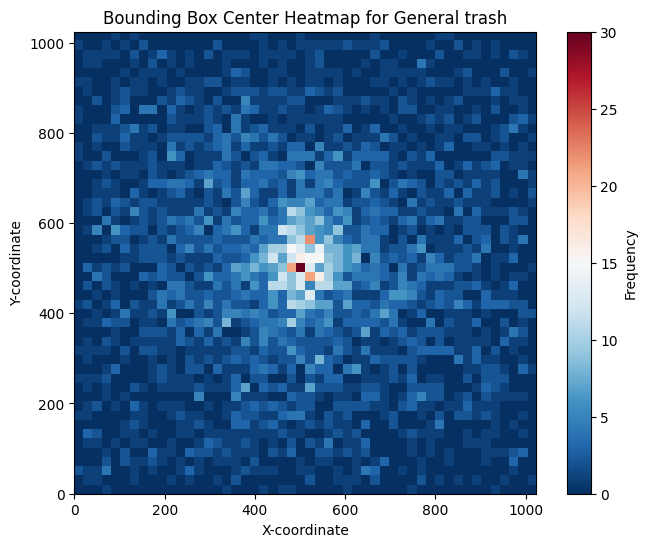

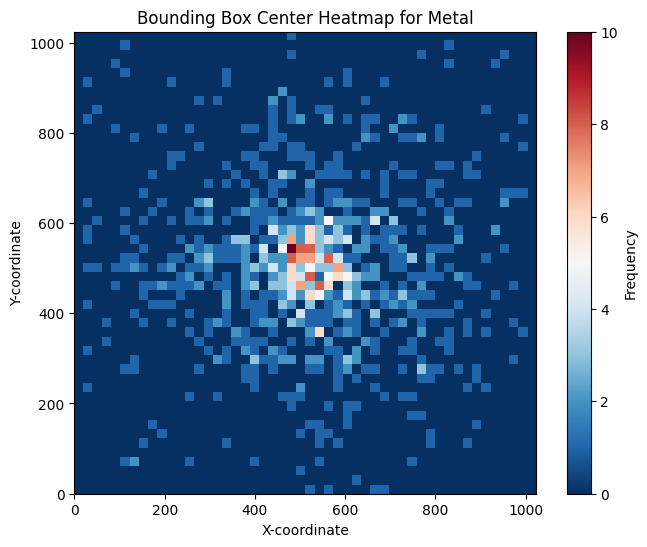

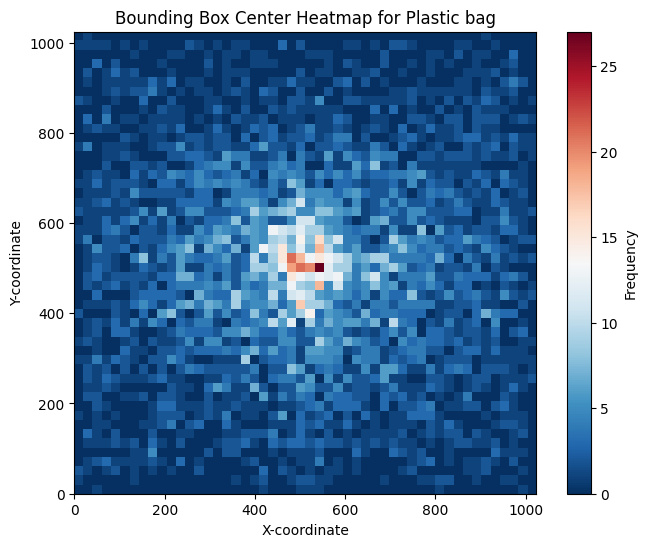

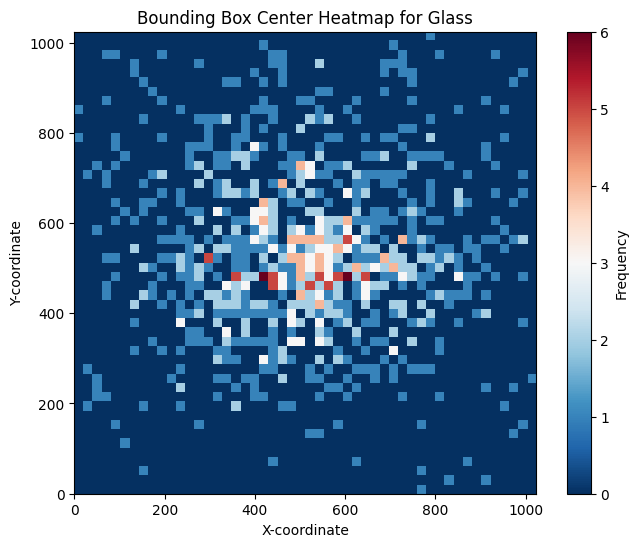

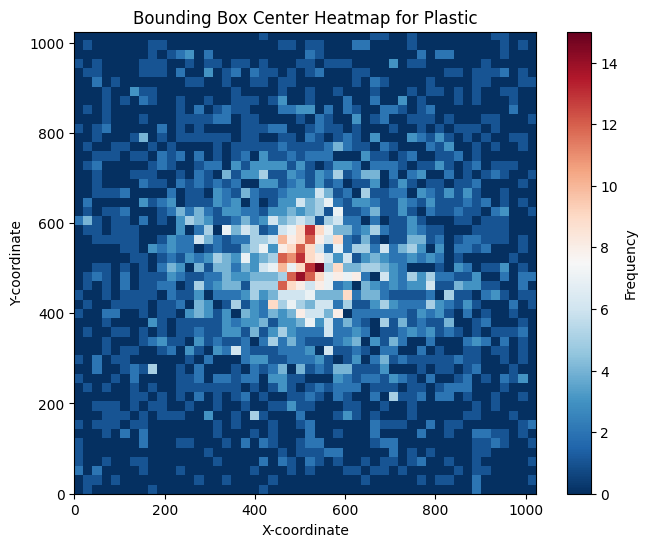

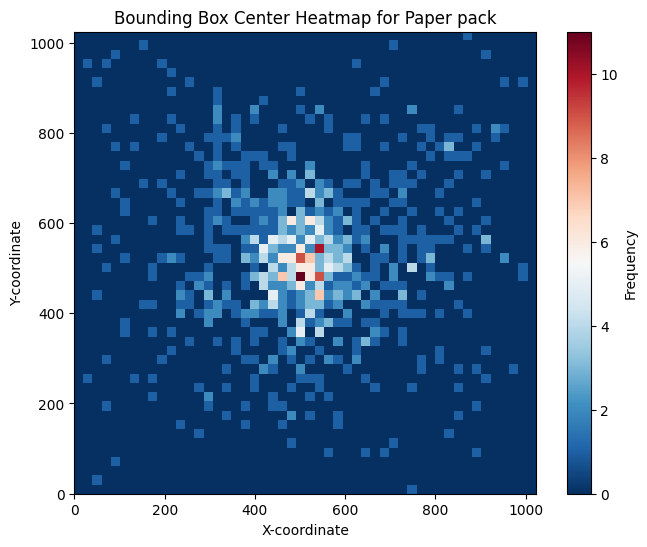

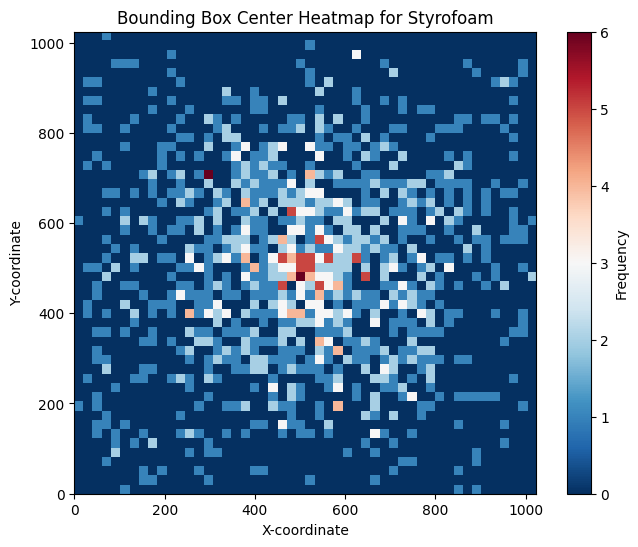

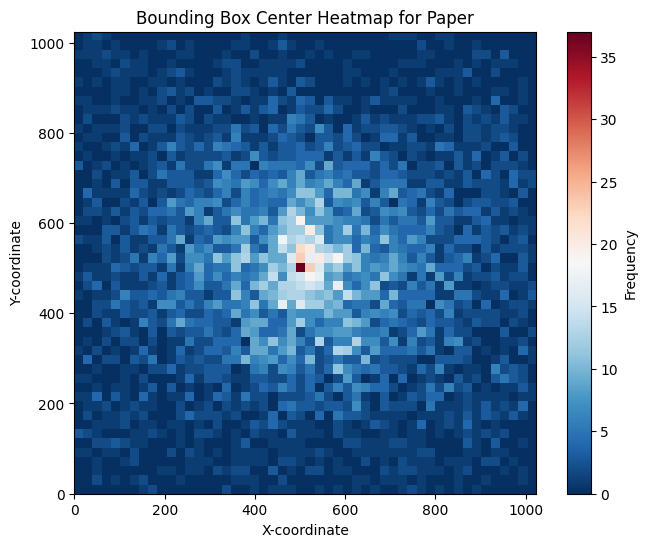

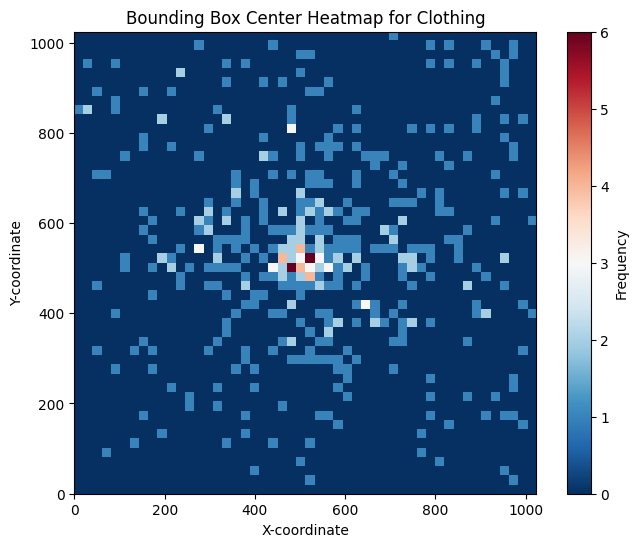

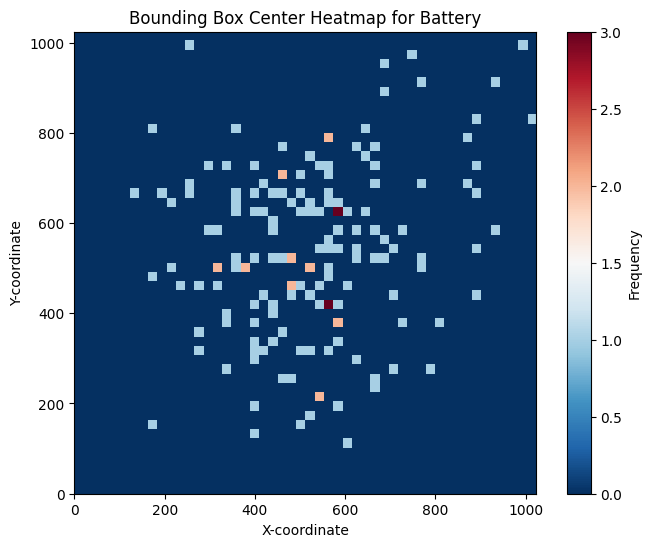

In [14]:
# 바운딩 박스 정보에서 중심 좌표 계산 (bbox는 [x, y, width, height] 형식)
df['bbox_x'] = df['bbox'].apply(lambda x: x[0])  # x 좌표
df['bbox_y'] = df['bbox'].apply(lambda x: x[1])  # y 좌표
df['bbox_width'] = df['bbox'].apply(lambda x: x[2])  # width
df['bbox_height'] = df['bbox'].apply(lambda x: x[3])  # height

# 바운딩 박스 중심 좌표 계산
df['center_x'] = df['bbox_x'] + df['bbox_width'] / 2
df['center_y'] = df['bbox_y'] + df['bbox_height'] / 2

# 이미지 크기 설정 (예: 1024x1024로 가정)
image_width = 1024
image_height = 1024

# 카테고리별 바운딩 박스 중심 좌표 추출 및 히트맵 생성
categories = df['Category Name'].unique()

for category in categories:
    category_data = df[df['Category Name'] == category]
    
    # 중심 좌표 추출
    centers_x = category_data['center_x']
    centers_y = category_data['center_y']
    
    # 히트맵 시각화
    plt.figure(figsize=(8, 6))
    heatmap, xedges, yedges = np.histogram2d(centers_x, centers_y, bins=50, range=[[0, image_width], [0, image_height]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='RdBu_r')
    plt.colorbar(label='Frequency')
    plt.title(f"Bounding Box Center Heatmap for {category}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.show()
    plt.close()

이미지 전체 크기와 Bounding Box 크기의 비율 분포

Text(0, 0.5, 'Frequency')

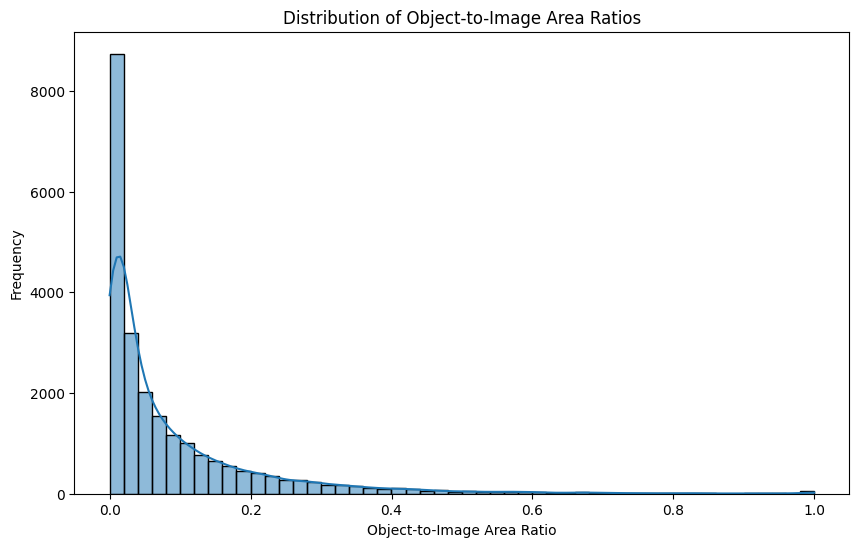

In [15]:
images = {img['id']: img for img in data['images']}  # 이미지 정보를 id 기준으로 매핑

# 객체 크기 비율 계산
ratios = []
for ann in annotations:
    img = images[ann['image_id']]
    img_area = img['width'] * img['height']  # 이미지의 전체 면적
    bbox_area = ann['area']  # 바운딩 박스의 면적
    ratio = bbox_area / img_area  # 객체가 이미지에서 차지하는 비율
    ratios.append(ratio)

# DataFrame 생성
df_ratios = pd.DataFrame({
    'Category ID': [ann['category_id'] for ann in annotations],
    'Ratio': ratios
})

# 히스토그램으로 객체 크기 비율 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df_ratios['Ratio'], bins=50, kde=True)
plt.title('Distribution of Object-to-Image Area Ratios')
plt.xlabel('Object-to-Image Area Ratio')
plt.ylabel('Frequency')